In [1]:
from IPython.display import Image
Image(url='https://i.imgur.com/DeB62Nl.png', width=500)

<div style="background-color: #ccffcc; padding: 10px;">

# This is the Leeds SciML Hackathon Tutorial Notebook.    
    
This notebook covers:
    
* How to download/access the Hackathon data
* Installing python environment (if applicable)
* Exploring the data set
* Example U-Net model and training
* Using [Weights & Biases and connecting with SciMl community]()
* Plotting metrics
* Evaluating the model Submitting Results     
    
*please ensure the suitable notebook is chosen for running on [remote/home machine](Introduction_own_notebook_server.ipynb), [Google CoLab](http://colab.research.google.com/github/cemac/SciML_sea_ice_hackathon_2023/blob/main/Introduction_Google_CoLab.ipynb) or **Jupyter99**)*     
    
## Useful Links 
    
* [Kaggle Competition Page](https://www.kaggle.com/competitions/leeds-sciml-sea-ice-segmentation)
* [Weights & Biases SciML Leeds team](https://wandb.ai/sciml-leeds)

    
    
</div>

In [3]:
from IPython.display import HTML
# For readability: disable warnings
import warnings
warnings.filterwarnings('ignore')
HTML('<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/U4amljFGkiw" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>')

<div style="background-color: #ccffcc; padding: 10px;">

# Data Download

**This notebook is for those using the JuyterHub99 server**
    
**If you're using [Google CoLab](http://colab.research.google.com/github/cemac/SciML_sea_ice_hackathon_2023/blob/main/Introduction_Google_CoLab.ipynb) or [Own Notebook Server](Introduction_own_notebook_server.ipynb) please used the linked notebooks**
    
* Create a Kaggle account: If you don't already have a Kaggle account, go to the Kaggle website (https://www.kaggle.com/) and sign up for an account.

* The data is already downloaded for you but you will need a kaggle account to submit your results    

</div>

<div style="background-color: #ccffcc; padding: 10px;">

The data is already split in to a **test** and **train** dataset for you at /storage/earth_data/sciml/


</div>

In [4]:
!ls /storage/earth_data/sciml/sciml
!echo 'number of test files is:'
!ls /storage/earth_data/sciml/sciml/test/* | wc -l
!echo 'number of training file is:'
!ls /storage/earth_data/sciml/sciml/train/* | wc -l

test  train
number of test files is:
704
number of training file is:
4221


# 🚀 Installing and importing

In [5]:
#import all the necessary libraries for this notebook

#weights and biases
import wandb
from wandb.keras import WandbCallback

#maths and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#machine learning
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence

#file system
import os, glob
import tifffile
from tqdm import tqdm

2023-06-20 14:34:51.284965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<div style="background-color: #ccffcc; padding: 10px;">
    
The `patch_paths` variables are arrays containing the names of the patch files.
Each patch patch has a corresponding SAR image, multispectral image, and label. (Except we've not given you the labels for the test patch paths).

</div>    

In [6]:
DATA_DIR = '/storage/earth_data/sciml/sciml'
train_patch_paths = np.array([os.path.basename(i[:-9]) for i in glob.glob(f'{DATA_DIR}/train/*_sar.tiff')])
test_patch_paths = np.array([os.path.basename(i[:-9]) for i in glob.glob(f'{DATA_DIR}/test/*_sar.tiff')])

#display patch paths
train_patch_paths

array(['Patch20190102_179_1320_240', 'Patch20190102_21_480_960',
       'Patch20191218_158_840_1200', ..., 'Patch20191218_172_960_360',
       'Patch20190102_51_360_240', 'Patch20190205_191_1080_1200'],
      dtype='<U27')

<div style="background-color: #ccffcc; padding: 10px;">

We use a data generator generates batches of data on-the-fly, reducing the memory requirements and enabling training on large datasets that may not fit entirely into memory.

</div>

In [18]:
def load_img(path):
    img = tifffile.imread(path)
    return img

class DataGenerator(Sequence):
    def __init__(self, patch_paths, data_dir, batch_size, split='train'):
        self.patch_paths = patch_paths
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.split = split

    def __len__(self):
        return len(self.patch_paths) // self.batch_size

    def __getitem__(self, index):
        batch_paths = self.patch_paths[index * self.batch_size:(index + 1) * self.batch_size]
        X_sar, X_ms, y = [], [], []
        
        for patch_path in batch_paths:
            
            try:
                sar_path = os.path.join(self.data_dir, self.split, patch_path + '_sar.tiff')
                ms_path = os.path.join(self.data_dir, self.split, patch_path + '_vis.tiff')
                if self.split != 'test':
                    label_path = os.path.join(self.data_dir, self.split, patch_path + '_ref.tiff')
                    label_arr = load_img(label_path)
                    y.append(label_arr)

                sar_arr = load_img(sar_path)
                ms_arr = load_img(ms_path)

                X_sar.append(sar_arr)
                X_ms.append(ms_arr)
                
            except Exception as e:
                print(e)
                continue

        X_sar = np.expand_dims(np.array(X_sar), -1)[:, ::3, ::3, :]
        X_ms = np.array(X_ms)
        if self.split != 'test':
            y = np.expand_dims(np.array(y), -1)
            return [X_sar, X_ms], y
        else:
            return [X_sar, X_ms], [None]*len(X_sar)
    
 

In [19]:
# Set batch size and train/test generator

batch_size = 16

# Split data into train and test sets
train_patch_paths, val_patch_paths = train_test_split(train_patch_paths, test_size=0.2, random_state=42)
train_generator = DataGenerator(train_patch_paths, DATA_DIR, batch_size)
val_generator = DataGenerator(val_patch_paths, DATA_DIR, batch_size)
test_generator = DataGenerator(test_patch_paths, DATA_DIR, batch_size, split='test')

<div style="background-color: #ccffcc; padding: 10px;">

# Defining the model    
    
The [U-Net](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/) model architecture is a convolutional neural network that consists of an encoder and a decoder.
The encoder extracts features from the input images, while the decoder upsamples the features to generate the final segmentation map.

The model is compiled with the [Adam optimiser](https://www.shiksha.com/online-courses/articles/adam-optimizer-for-stochastic-gradient-descent/) and [binary cross-entropy loss](https://insideaiml.com/blog/BinaryCross-Entropy-1038).
During training, the validation data is used to monitor the performance of the model and early stopping is applied to prevent overfitting.

# Weight and Biases    
           
The training progress can be logged using the wandb library, which allows tracking and visualisation of metrics in a web interface.
    
## ✅ Sign Up

Sign up to a free [Weights & Biases account here](https://wandb.ai/signup)

[Weights and Biases docs](https://docs.wandb.ai/quickstart)

</div>

In [20]:
def unet():
    # Input layers
    input_sar = Input((240, 240, 1))
    input_ms = Input((240, 240, 3))
    
    # Resizing input_sar
    # resized_ms = UpSampling2D(size=(3, 3))(input_ms)

    # Concatenate inputs
    concat = concatenate([input_sar, input_ms], axis=-1)
    
    # Encoding path
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bridge
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoding path
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    # Output layers
    output = Conv2D(1, 1, activation = 'sigmoid')(conv7)
    output = UpSampling2D(size=(4, 4))(output)

    # Model
    model = Model(inputs=[input_sar, input_ms], outputs=output)

    return model

# Create model
model = unet()

In [21]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_generator,
          validation_data=test_generator,
          epochs=10,
          use_multiprocessing=True,
          workers=6)

<div style="background-color: #ccffcc; padding: 10px;">
  
# Training the model
    
if you have signed up for weights and biases then set `wandb_enabled = True`, if not then set to `False`
    
The cell below will train the model and capture some metrics
    
**If not part of the sciml-leeds group on weights and biases then remove**
    
```python
entity='sciml-leeds'
```
    
    
</div>

In [22]:
# Initialize a new W&B run
wandb_enabled = False
train_local = False

if train_local:
    earlystopper = EarlyStopping(patience=5, verbose=1)
    if wandb_enabled:
        wandb.init(entity='sciml-leeds', project='sea-ice-segmentation')
        history = model.fit(train_generator,
              validation_data=val_generator,
              epochs=10,
              use_multiprocessing=True,
              workers=6,
              callbacks=[earlystopper, WandbCallback()])
        wandb.finish()
    else:
        history = model.fit(train_generator,
              validation_data=val_generator,
              epochs=10,
              use_multiprocessing=True,
              workers=6,
              callbacks=[earlystopper])
else:
    print('load pretrained model as no GPUS')



load pretrained model as no GPUS


<div style="background-color: #ccffcc; padding: 10px;">
    

# Saving/Loading Model Weights

[Keras can save the model](https://www.tensorflow.org/guide/keras/serialization_and_saving) so you only have to train the model once! Here we've save just the model weights to allow results to be seen 

</div>

In [23]:
# Uncomment as appropriate to save your model or load the tutorial model (jupyterhub 99 might be slow so load pretrained)

#model.save_weights('model/tutorial/exampleUNet.ckpt')

model.load_weights('/storage/earth_data/sciml/model/tutorial/exampleUNet.ckpt')

<div style="background-color: #ccffcc; padding: 10px;">
    
# Visualization    
    
Let's dive into the visualization of our sea ice segmentation results using the validation dataset. By running the code snippet provided, we obtain valuable insights into the model's performance and its ability to accurately identify sea ice boundaries.

First, the model makes predictions on the validation dataset using the `model.predict()` function. The resulting predictions are stored in the variable preds. These predictions represent the segmentation masks, indicating the presence or absence of sea ice in the images.

Next, we extract a single batch of data from the validation generator using `next(iter(val_generator))`. This batch consists of SAR (Synthetic Aperture Radar) images, multispectral (MS) images, and their corresponding ground truth segmentation masks. These components are unpacked into the variables `X_sar_test`, `X_ms_test`, and `y_test`, respectively.

Now, we proceed to visualize the results. Within a loop, we iterate over the predictions stored in preds. For each prediction, we create a figure with a grid layout of four subplots.

The first subplot, labeled "SAR Image," displays the SAR image from the validation set. SAR imagery provides valuable information about the surface characteristics of sea ice.

The second subplot, labeled "MS Image," showcases the multispectral image captured during the validation process. Multispectral data enables us to analyze sea ice from different spectral perspectives.

Moving on to the third subplot, titled "Segmentation Mask," we observe the model's predicted segmentation mask. The thresholding operation (`preds[i,:,:,0]>threshold`) helps us visualize the predicted sea ice boundaries clearly.

Lastly, the fourth subplot, labeled "Ground Truth," presents the actual ground truth segmentation mask obtained from the validation dataset. This serves as a reference to assess the accuracy of our model's predictions.

By carefully examining these subplots, we can compare the model's predictions against the ground truth and gain insights into the performance and limitations of our sea ice segmentation model.
    
 </div>

<div style="background-color: #ccffcc; padding: 10px;">
    
You need to specify the threshold value, which determines the threshold for classifying pixels as foreground or background. Adjusting this value may affect the performance of the segmentation.

```python
threshold = <THRESHOLD>
```    

Where `<THRESHOLD>` is a value between 0 and 1    
    
</div>    

In [24]:

threshold = 0.3 #@param {type:"slider", min:0, max:1, step:0.1}

1/1 [==============================] - 17s 17s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


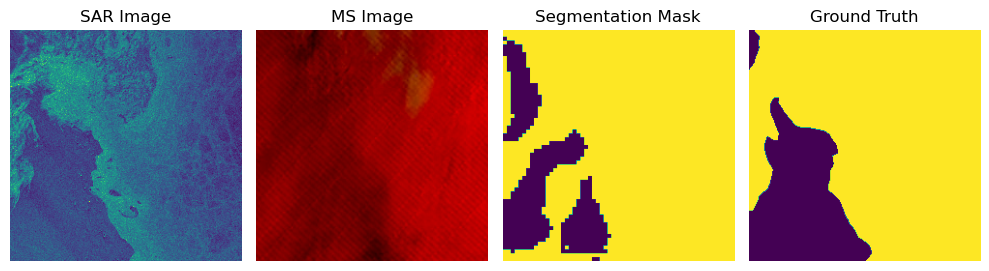

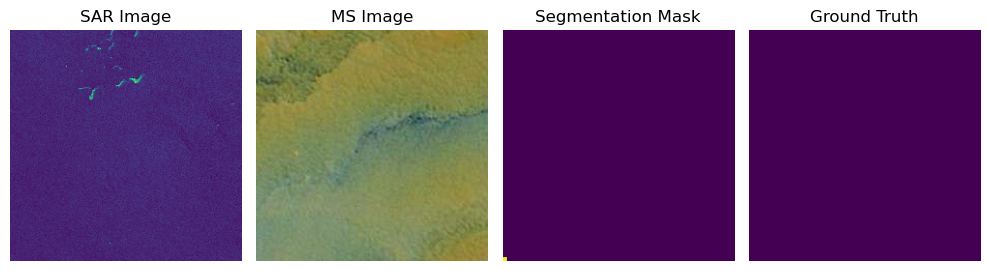

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


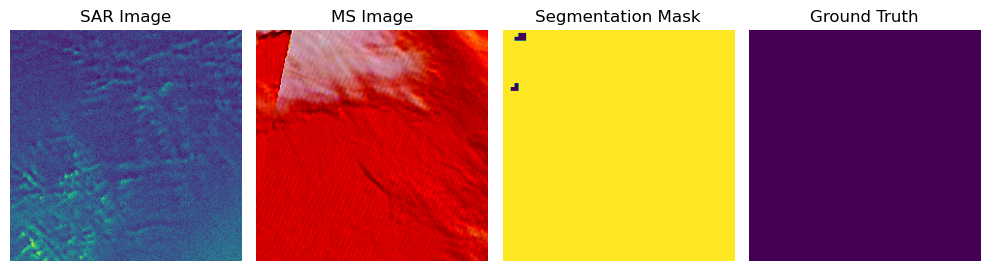

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


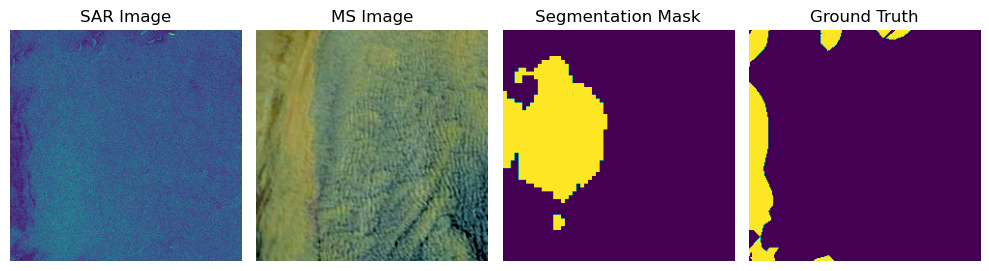

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


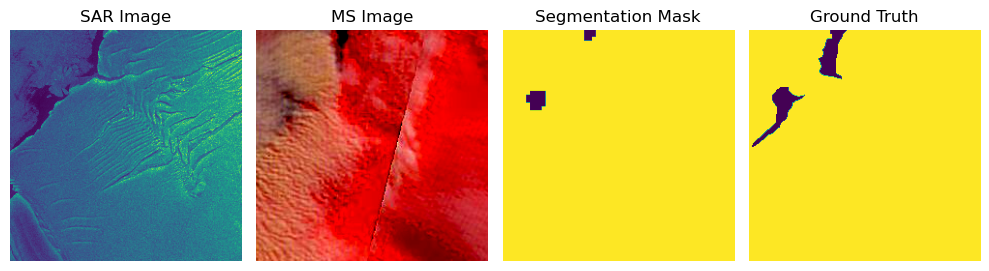

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


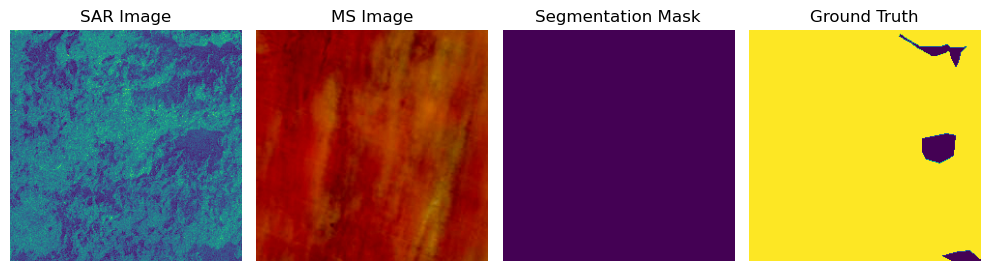

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


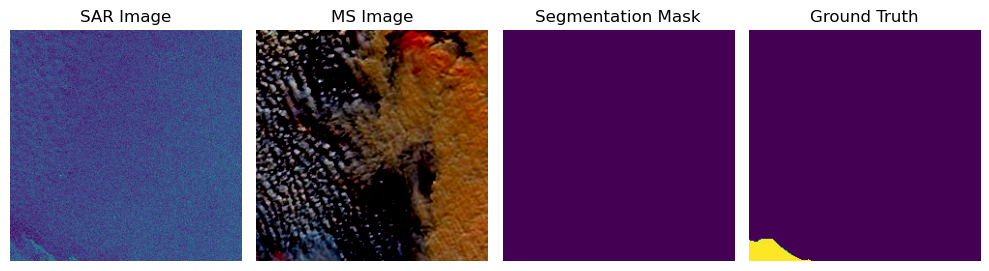

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


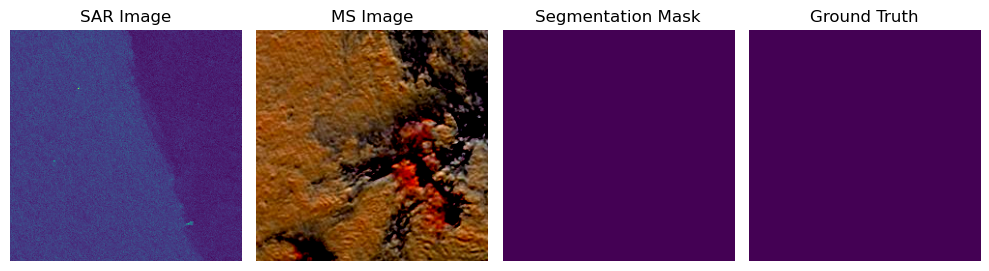

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


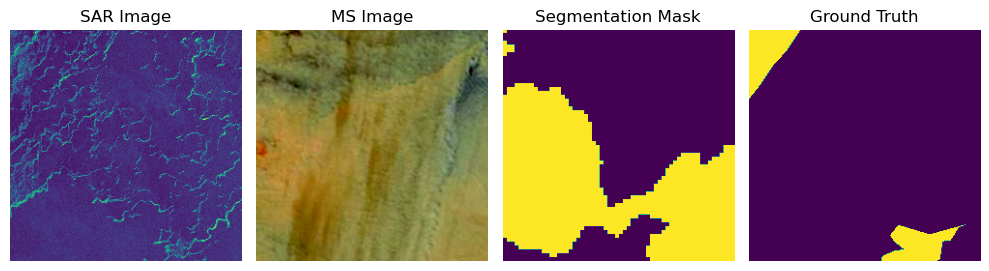

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


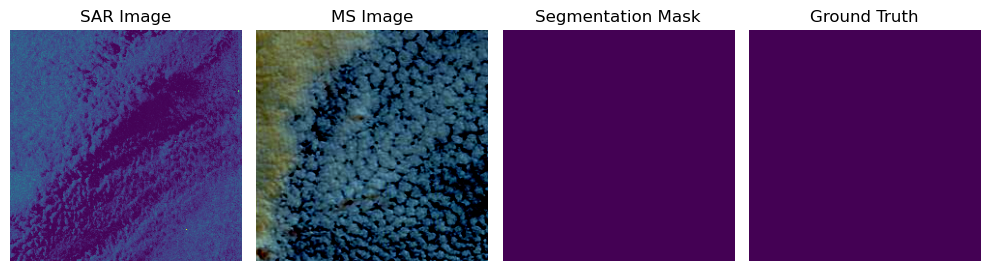

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


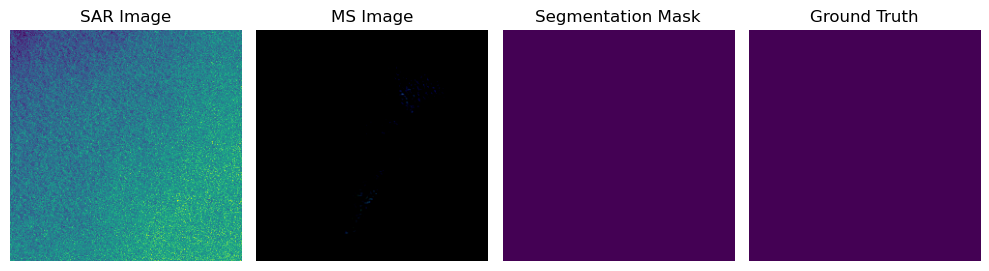

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


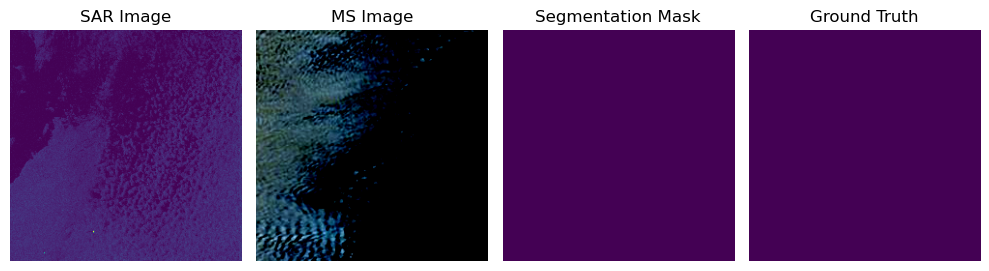

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


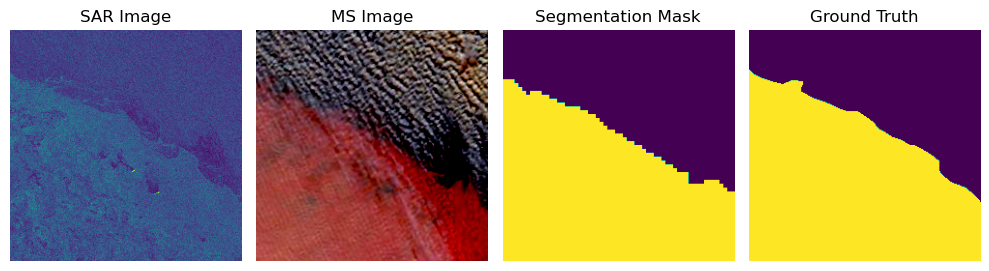

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


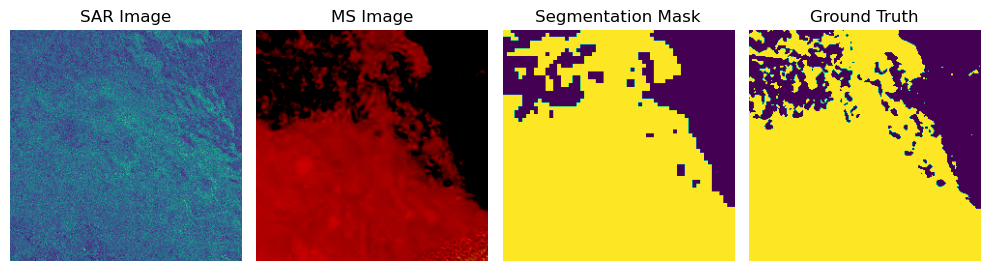

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


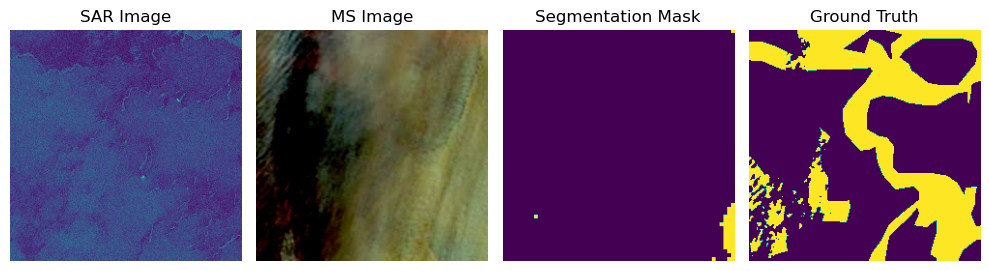

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


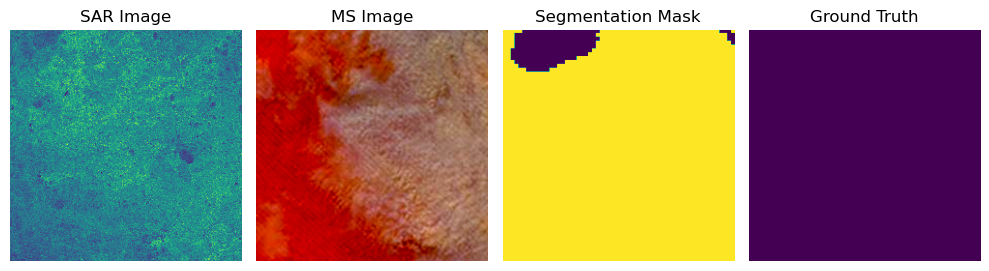

In [25]:
preds = model.predict(val_generator,steps=1)

(X_sar_test, X_ms_test), y_test = next(iter(val_generator))

for i in range(preds.shape[0]):
    plt.figure(figsize=(10, 5))
    plt.subplot(141)
    plt.imshow(X_sar_test[i,:,:,:])
    plt.title('SAR Image')
    plt.axis('off')
    plt.subplot(142)
    plt.imshow(X_ms_test[i,:,:,:])
    plt.title('MS Image')
    plt.axis('off')
    plt.subplot(143)
    plt.imshow(preds[i,:,:,0]>threshold)
    plt.title('Segmentation Mask')
    plt.axis('off')
    plt.subplot(144)
    plt.imshow(y_test[i,:,:,0])
    plt.title('Ground Truth')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

<div style="background-color: #ccffcc; padding: 10px;">

# Things to think about    
    
* Are there any notable differences between the predicted segmentation mask and the ground truth?
* How does adjusting the threshold value impact the visualisation of the segmentation mask?
* Can you identify any challenging areas where the model struggles to accurately predict sea ice boundaries?
* What potential implications can accurate sea ice segmentation have on environmental research and decision-making processes?
    

</div>

<div style="background-color: #ccffcc; padding: 10px;">

# Generate Submission
Ta-da! 📝🎉 Our model is trained and ready, and it's time to run our predictions on the test set and create the submission file.

A submission file named 'submission.csv' is created to store the predictions.
For each image in the test set, the image ID and run-length encoded pixels are written to the file.

Taken from [kaggle example](#ref:https://www.kaggle.com/paulorzp/run-length-encode-and-decode)    
    
**JupyterHub 99 may take a while to run this so please set `JupyterHub99_predict = False` to run**
    
</div>

In [31]:
#ref:https://www.kaggle.com/paulorzp/run-length-encode-and-decode.

def rle_encode(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

JupyterHub99_predict=False

if JupyterHub99_predict:
# Predict on test data
    predictions = model.predict(test_generator)

    # Generate submission DataFrame
    submission_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])

    for i, patch_path in enumerate(test_patch_paths):
        image_id = os.path.basename(patch_path)
        mask = predictions[i, :, :, 0] > threshold
        encoded_pixels = rle_encode(mask)
        submission_df.loc[i] = [image_id, encoded_pixels]

    # Save submission DataFrame to CSV file
    submission_df.to_csv('submission.csv', index=False)
else:
    print('not running unless jupyterhub99_predict is set to True')

not running unless jupyterhub99_predict is set to True


<div style="background-color: #ccffcc; padding: 10px;">
    
    
The scoring metric will be Intersection over Union (IoU) which will be evaluted from the submission.csv generated
    
* [Evaluating your Segmentation model](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2)
* [Intersection over Union (IoU)](https://hasty.ai/docs/mp-wiki/metrics/iou-intersection-over-union)
    
</div>

<div style="background-color: #ccffcc; padding: 10px;">
   
# Submitting your score    
    
After logging in to Kaggle, go to your account settings page. Scroll down to the section titled "API" and click on the "Create New API Token" button. Copy and paste your username and key into the cell below to allow for submission of your results
    

    
    
</div>

In [32]:


import os
os.environ["KAGGLE_USERNAME"]="yourusername"
os.environ["KAGGLE_KEY"]="yourapikey"




In [33]:
!kaggle competitions list

ref                                                                                           deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/asl-fingerspelling                                        2023-08-24 23:59:00  Research          $200,000        369           False  
https://www.kaggle.com/competitions/2023-kaggle-ai-report                                     2023-07-05 23:59:00  Analytics          $70,000        107           False  
https://www.kaggle.com/competitions/icr-identify-age-related-conditions                       2023-08-10 23:59:00  Featured           $60,000       3311           False  
https://www.kaggle.com/competitions/predict-student-performance-from-game-play                2023-06-28 23:59:00  Featured           $55,000    

In [ ]:


!kaggle competitions files leeds-sciml-sea-ice-segmentation



In [ ]:
!kaggle competitions submit -c leeds-sciml-sea-ice-segmentation  -f submission.csv -m "Submission via API"

In [ ]:


!kaggle competitions submissions -c leeds-sciml-sea-ice-segmentation



In [ ]:
!kaggle competitions  leaderboard leeds_sciml-sea-ice-segmentation --show